In [2]:
# !pip install -qq streamlit
# !pip install -qq perceptilabs
!pip install -qq pyvo numba imageio click requests tqdm pyspng ninja imageio-ffmpeg==0.4.3

### Packages

In [3]:
import numpy as np, pandas as pd, pyvo as vo, pickle as pkl
import glob, imageio, os, math, re, time, shutil, requests, scipy, random, numba

from itertools import islice
from PIL import *
from pprint import pprint
from tqdm import tqdm
from datetime import date
from math import pi
from astropy.constants import G, M_sun, M_jup, M_earth, GM_sun, au, R_earth


from fastai import *
from fastai.data.all import *
from fastai.vision.all import *
from fastai.vision.gan import *

import tensorflow as tf
from tensorflow.keras import layers

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from IPython import display

### Constants

In [4]:
BUFFER_SIZE = 64
BATCH_SIZE = 32
IMG_SIZE = 256
EPOCHS = 1000
noise_dim = 10
num_examples_to_generate = 9
generator_lr = .001
discriminator_lr = .0001

### NGrok

In [5]:
!ngrok authtoken 2AOaSRQ4dVkmfpOEOJAxlOyDXlv_3pURLRczacpoAyDJXqBP4

/bin/bash: ngrok: command not found


### Data Management



##### Exoplanet Archive

In [6]:
try:
    frame = pd.read_pickle('/kaggle/working/dataframe.pkl')
except: 
    # Initial Selection of Variables
    variables = ['hostname', 'pl_letter', 'pl_rade', 'pl_bmasse','pl_dens', 'pl_orbsmax', 'pl_orbper', 
                   'pl_orbeccen', 'st_spectype', 'st_rad', 'st_teff', 'st_mass']
    service = vo.dal.TAPService('https://exoplanetarchive.ipac.caltech.edu/TAP/sync')
    results = service.search(f'SELECT {", ".join(variables)} FROM ps')
    # Data Conversion
    frame = pd.DataFrame(results)
    # Removed RV_AMP because of transit measurements (e.g. TRAPPIST-1)
    frame = frame[variables]
    frame.rename(columns = {'hostname':'Hostname', 'pl_letter':'Letter', 'pl_rade': 'Earth Radii', 'pl_bmasse':'Earth Masses', 
                            'pl_dens':'Density (g/m^3)', 'pl_orbsmax':'Semi-Major Axis', 'pl_orbper':'Orbital Period',
                            'pl_orbeccen':'Eccentricity', 'st_spectype':'Spectral Type', 'st_rad':'Star Radius',
                            'st_teff':'Star Temperature', 'st_mass':'Star Mass'}, inplace=True)
    # frame[['pl_rade']] *= 12756.20/2
    # frame.rename(columns = {'pl_rade':'pl_rad'}, inplace=True)
    types = []
    for label, content in frame.iterrows():
        rad = float(content['Earth Radii'])
        mass = float(content['Earth Masses'])
        type = '?'
        if rad < 2.2 or mass < 5:
            type = 'rocky'
        elif 2.2 <= rad < 6 or 5 < mass < 20:
            type = 'icy'
        elif 6 <= rad or mass > 30:
            type = 'gassy'
        types.append(type)
    #     density = float(content['pl_dens'])
    #     if density:
    #         volume = math.pi * (rad * 12756.20) ** 2
    frame['Planet Type'] = types

    #not doing this because some planets do not have all measurements.
    #frame = frame.dropna()
    # frame.loc[(frame['Hostname'] == '55 Cnc') & (frame['Letter'] == 'e')]    
    frame.to_pickle('/kaggle/working/dataframe.pkl')
# frame

## Planetary Spectrum Generator Data

In [7]:
for label, content in tqdm(frame.head().iterrows()):
#     print(content)
    f = open('config.txt', 'w+')
    f.write('<OBJECT>Exoplanet')
    f.write(f'<OBJECT-NAME>{content["Hostname"]} {content["Letter"]}\n')
    f.write(f'<OBJECT-DIAMETER>{2*12756.2*content["Earth Radii"]}')
    # Gravitational Constant * Density * Pi because M/R^2 = D*Pi
    f.write(f'<OBJECT-GRAVITY>{G * (content["Density (g/m^3)"]*math.pi)}')
    f.write(f'<OBJECT-STAR-RADIUS>{content["Star Radius"]}')
    f.write(f'<OBJECT-STAR-TYPE>{content["Spectral Type"]}')
    f.write(f'<OBJECT-ECCENTRICITY>{content["Eccentricity"]}')
    # r_p = a(1 - e)
    f.write(f'<OBJECT-PERIAPSIS>{content["Semi-Major Axis"] * (1 - content["Eccentricity"])}')
    f.write(f'<OBJECT-PERIOD>{content["Orbital Period"]}')
#     !curl --data-urlencode file@config.txt https://psg.gsfc.nasa.gov/api.php
#     print(f"{content['Hostname']} {content['Letter']} is complete")

5it [00:00, 419.10it/s]


## Image Modification

In [8]:
name_splitter = re.compile(r' |_')
planets = {}

exopath = '../working/exoplanets'
if os.path.exists(exopath):
    shutil.rmtree(exopath)
os.mkdir(exopath)

for root, _, images in os.walk('../input/images'):
    for image in images:
        path = f'{root}/{image}'
        img = Image.open(path).convert(mode='RGB')
        img = img.resize((IMG_SIZE, IMG_SIZE))
        planet = image.replace('_', ' ')[:image.index('.')]
        index = 0
        while os.path.exists(f'{exopath}/{planet}({index}).png'):
            index += 1
        img.filename = f'{planet}({index}).png'
        img.save(f'{exopath}/{img.filename}')
        if planet not in planets: 
            planets[planet] = []
        planets[planet].append(img)

datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    featurewise_center=True,
    rotation_range=15,
    width_shift_range=16,
    height_shift_range=16,
    
    horizontal_flip=True,
    vertical_flip=True,
)        

images_to_augment = 65 * 63
def image_augmentation(num: int):
    for i in tqdm(range(num)):
        r = random.random()
        planet = random.choice(list(planets.keys()))
        chosen = random.choice(planets[planet])
        choice = np.asarray(chosen)
        choice_mod = choice.copy()
        if r > 0.75:
            choice_mod = scipy.ndimage.rotate(choice, angle=random.randint(-30, 30), reshape=False, mode='nearest')
    #         for i in range(choice_mod.shape[0]):
    #             for j in range(choice_mod.shape[1]):
    #                 if not any(choice_mod[i][j]):
    #                     choice_mod[i][j] = choice[i][j]
        r = random.random()
        if r > 0.5:
            degree = 2 * pi * random.random()
            displacement = random.randint(1, 20)
            shift = tuple(map(int, (displacement * math.cos(degree), displacement * math.sin(degree), 0)))
            choice_mod = scipy.ndimage.shift(choice, shift, mode='nearest')

        new_img = Image.fromarray(choice_mod)
        new_img.info = chosen.info
        new_img.filename = chosen.filename
        planets[planet].append(new_img)

## Remaking DataFrame

In [9]:
to_rename = {'PSR B125712':'PSR B1257+12', 'TIC 172900988':'TIC 172900988 Aa', '51 PEG':'51 Peg'}
renamer = re.compile(r".*(PSR B125712|TIC 172900988|PEG).*")

planet_arrays = np.array([[]], dtype=object)
for planet in planets:
    hostname, letter = planet.rsplit(' ', maxsplit=1)
    match = renamer.match(hostname)
    if match:
        hostname = hostname.replace(match.group(0), to_rename[match.group(0)])
    pl_arr = np.array([[]], dtype=object)
    pl_type = '?'
    for label, content in frame.loc[(frame['Hostname'] == hostname) & (frame['Letter'] == letter)].iterrows():
        pl = np.array([[content['Earth Radii'], content['Earth Masses'], content['Semi-Major Axis'], content['Orbital Period'], 
                        content['Eccentricity'], content['Star Radius'], content['Star Temperature'], content['Star Mass']]], dtype=float)
        if pl_type == '?':
            pl_type = content['Planet Type']
        pl_arr = np.concatenate((pl_arr, pl), axis=0) if pl_arr.size else pl
    if not pl_arr.size:
        print(f'\x1b[31m{planet}\x1b[0m')
        continue
    print(f'\x1b[32m{planet}\x1b[0m')
#     print([[f for f in pl_arr[:, i] if f != float('nan')] for i in range(pl_arr.shape[1])])
    pl_mean = np.array([[np.mean([pl_arr[:, i][~np.isnan(pl_arr[:, i])]]) for i in range(pl_arr.shape[1])]])
    pl_final = np.concatenate((np.array([[planet]], dtype=object), pl_mean, np.array([[pl_type]], dtype=object)), axis=1)
    planet_arrays = np.concatenate((planet_arrays, pl_final), axis=0) if planet_arrays.size else pl_final
    
# print(planet_arrays)
        

GJ 436 b
Kepler-69 c
TRAPPIST-1 d
GJ 581 c
NGC 2682 YBP 1194 b
Kepler-22 b
TRAPPIST-1 f
TRAPPIST-1 g
55 Cnc e
GJ 504 b
HR 8799 e
Kepler-47 c
NGTS-1 b
Kepler-186 f
TRAPPIST-1 e
Kepler-7 b
PSR B125712 b
Kepler-16 b
HD 189733 b
TRAPPIST-1 c
L 98-59 b
GJ 667 C b
Kepler-47 b
TIC 172900988 b
HD 85512 b
TRAPPIST-1 b
GJ 1214 b
TYC 8998-760-1 b
WASP-12 b
GJ 1132 b
Kepler-452 b
Kepler-62 f
Kepler-20 e
Kepler-37 b
KELT-9 b
TOI-849 b
WASP-96 b
Kepler-10 c
AU Mic b


/opt/conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


TRAPPIST-1 h
51 PEG b
HIP 67522 b
HD 17156 b
kap And b
Kepler-62 e
KOI-55 b


In [10]:
df = pd.DataFrame(planet_arrays)
df.index = df.index.map(str)
df.index = df[0]
del df[0]
df.columns =['Earth Radii', 'Earth Masses', 'Semi-Major Axis', 'Orbital Period', 'Eccentricity', 'Star Radius', 'Star Temperature', 'Star Mass', 'Planet Type']
df.index.name = 'Planet'
# df['Image Path'] = [planet_paths[planet] for planet in planets]
df = df.sort_index()
df['Eccentricity'] = df['Eccentricity'].fillna(0)
spd = 86400 # Seconds Per Day
dens = {'rocky': 5.1*(100**3)/1000, 'gassy': 0.9*(100**3)/1000, 'icy': 1.4*(100**3)/1000}
for label, content in df.iterrows():
    if np.isnan(content['Orbital Period']):
        df.at[label, 'Orbital Period'] = 2 * pi * math.sqrt((content['Semi-Major Axis'] * au.value)**3/(content['Star Mass'] * GM_sun.value)) / spd
    if np.isnan(content['Semi-Major Axis']):
        df.at[label, 'Semi-Major Axis'] = ((GM_sun.value * content['Star Mass'] * (content['Orbital Period'] * spd) ** 2)/(4 * pi ** 2)) ** (1/3) / au.value
    if np.isnan(content['Earth Radii']):
        df.at[label, 'Earth Radii'] = (0.75 * content['Earth Masses'] * M_earth.value /(dens[content['Planet Type']] * pi)) ** (1/3) / R_earth.value
    if np.isnan(content['Earth Masses']):
        df.at[label, 'Earth Masses'] = ((4/3) * pi * (content['Earth Radii'] * R_earth.value) ** 3 * (dens[content['Planet Type']])) / M_earth.value

df.at['TYC 8998-760-1 b', 'Star Radius'] = 1.01
df.at['kap And b', 'Star Radius'] = 2.29
df.at['PSR B125712 b', 'Star Temperature'] = 28_856
df.at['PSR B125712 b', 'Star Radius'] = 0.000015
# df['Planet Type'] = 2 * (df['Planet Type'] == 'gassy') + (df['Planet Type'] == 'icy')
# df['Planet Type'] = [[[0, 0, 1], [0, 1, 0], [1, 0, 0]][pl_type] for pl_type in df['Planet Type']]
for pl_type in df['Planet Type'].unique():
    df[f'Is {pl_type.capitalize()}'] = df['Planet Type'] == pl_type
df = df.drop('Star Radius', axis=1)
df = df.drop('Planet Type', axis=1)
df

,Earth Radii,Earth Masses,Semi-Major Axis,Orbital Period,Eccentricity,Star Temperature,Star Mass,Is Gassy,Is Rocky,Is Icy
Planet,,,,,,,,,,
51 PEG b,9.67568,148.360256,0.052262,4.23053,0.003440,5763.92,1.046667,True,False,False
55 Cnc e,1.97125,8.673422,0.019644,1.054399,0.081625,5240.535455,0.916923,False,True,False
AU Mic b,4.1225,24.62588,0.06485,8.46307,0.089200,3677.6,0.5,False,False,True
GJ 1132 b,1.23375,1.6225,0.015315,1.62893,0.110000,3247.333333,0.18,False,True,False
GJ 1214 b,2.647125,6.705208,0.014505,1.580404,0.050750,3074.692308,0.166667,False,False,True
GJ 436 b,4.1046,22.681156,0.028814,2.64171,0.157497,3452.881875,0.4475,False,False,True
GJ 504 b,19.799687,1271.3,43.5,94875.132851,0.000000,6234.0,1.22,True,False,False
GJ 581 c,2.773083,5.433094,0.072537,12.91914,0.075400,3427.463333,0.3125,False,False,True
GJ 667 C b,2.807059,5.63525,0.049983,7.20024,0.143500,3550.0,0.33,False,False,True


In [11]:
for planet, images in planets.items():
    for image in images:
        image.info = np.expand_dims(np.asarray(df.loc[planet], dtype=np.float32), axis=0)
#         image.info = np.array([df.loc[planet]['Planet Type']])

## Data Loading

In [12]:
try:
    resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
    tf.config.experimental_connect_to_cluster(resolver)
    # This is the TPU initialization code that has to be at the beginning.
    tf.tpu.experimental.initialize_tpu_system(resolver)
    print("All devices: ", tf.config.list_logical_devices('TPU'))
    strategy = tf.distribute.TPUStrategy(resolver)
except ValueError:
    print('\x1b[31mNo TPU found\x1b[0m')

No TPU found


In [13]:
image_labels = np.array([[label, image.filename, image, image.info] for label, images in planets.items() for image in images], dtype=object)
labels, filenames, images, images_arrs, image_info = np.array(image_labels[:, 0]), np.array(image_labels[:, 1]), np.array(image_labels[:, 2]), np.array([*map(np.asarray, image_labels[:, 2])]), np.concatenate(image_labels[:, 3], axis=0)
print(labels.shape, filenames.shape, images.shape, images_arrs.shape, image_info.shape)

(65,) (65,) (65,) (65, 256, 256, 3) (65, 10)


# Actual Machine Learning

In [14]:
datagen.fit(images_arrs, augment=True)

In [15]:
def make_discriminator_model():

    model = tf.keras.Sequential()

    model.add(layers.Conv2D(128, 4, strides=2, padding='same',
                                     input_shape=[IMG_SIZE,IMG_SIZE,3]))
    
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(64, 4, strides=2, padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Conv2D(32, 45, strides=2, padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Conv2D(16, 4, strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation='sigmoid'))

    return model

In [16]:
# with strategy.scope():
discriminator = make_discriminator_model()
print (discriminator.summary())

decision = discriminator.predict(images_arrs)
print()
# print ("Prediction for image from training data:", decision)

2022-11-29 13:49:06.812413: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-29 13:49:06.813563: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-29 13:49:06.814252: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-29 13:49:06.815437: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 128)     6272      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 128, 128, 128)     0         
_________________________________________________________________
dropout (Dropout)            (None, 128, 128, 128)     0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 64)        131136    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 64, 64, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        4

2022-11-29 13:49:12.527716: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-11-29 13:49:13.566204: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


In [17]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(32*32*32*3, use_bias=False, input_shape=(image_info.shape[1] + noise_dim,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((32, 32, 32*3)))
    assert model.output_shape == (None, 32, 32, 32*3)

    model.add(layers.Conv2DTranspose(32*3, 4, strides=2, padding='same', use_bias=False))
    assert model.output_shape == (None, 64, 64, 32*3)
    # Hint: What shape is the image at this point? How many filters does the most recent layer have?
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(16*3, 4, strides=2, padding='same', use_bias=False))
    assert model.output_shape == (None, 128, 128, 16*3)
    # Hint: How and why has our image shape changed?
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(3, 4, strides=2, padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, IMG_SIZE, IMG_SIZE, 3)
    return model

In [18]:
def scale_and_show(img):
    plt.imshow(img)

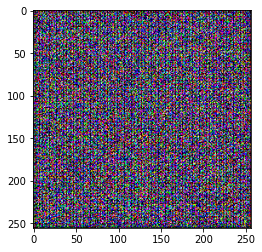

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 98304)             1966080   
_________________________________________________________________
batch_normalization (BatchNo (None, 98304)             393216    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 98304)             0         
_________________________________________________________________
reshape (Reshape)            (None, 32, 32, 96)        0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 64, 64, 96)        147456    
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 96)        384       
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 64, 64, 96)       

In [19]:
# with strategy.scope():
generator = make_generator_model()

noise = tf.concat((tf.random.normal([image_labels.shape[0], noise_dim]), tf.convert_to_tensor(image_info, dtype=tf.float32)), axis=1)
generated_image = generator(noise, training=False)

scale_and_show(generated_image[0])
plt.show()

print(generator.summary())

In [20]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [21]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [22]:
def generator_loss(disc_fake_output):
    loss = cross_entropy(tf.ones_like(disc_fake_output), disc_fake_output)
    return loss 

In [23]:
generator_optimizer = tf.keras.optimizers.Adam(generator_lr)
discriminator_optimizer = tf.keras.optimizers.Adam(discriminator_lr)

#We'll reuse input to the generator in our GIF
seed = tf.random.normal([num_examples_to_generate, image_info.shape[1] + noise_dim]) 

#Packaging up our training images as a Dataset object
train_dataset = tf.data.Dataset.from_tensor_slices(images_arrs).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
train_dataset = datagen.flow(images_arrs, image_info, batch_size=BATCH_SIZE)

In [24]:
@tf.function
def train_step(images, data=None):
    if data is None:
        data = tf.concat((tf.random.normal([image_info.shape[0], noise_dim]), 
                           tf.convert_to_tensor(image_info, dtype=tf.float32)), axis=1)
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        #Make images:
        generated_images = generator(data, training=True)

        #Get the discriminator's output:
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #Calculate each network's loss:
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    #Update each network's weights to (hopefully) reduce the loss next time:
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [25]:
def generate_and_save_images(model, epoch, test_input, dir_name):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(3,3))

    for i in range(predictions.shape[0]):
        plt.subplot(3, 3, i+1)
        scale_and_show(predictions[i])
        plt.axis('off')
    
    plt.savefig(f'/kaggle/working/images/{dir_name}/image_at_epoch_{epoch:04d}.png')
    plt.show() 

In [26]:
def train(dataset, epochs):
    save_version = 0
    while os.path.exists(f'/kaggle/working/images/{date.today()}_{save_version}'):
        save_version += 1
    dir_name = f'{date.today()}_{save_version}'
    os.mkdir(f'images/{dir_name}')

    for epoch in range(epochs):
        start = time.time()

        for image_batch in dataset:
            if isinstance(image_batch, tuple):
                train_step(*image_batch)
            else:
                train_step(image_batch)
    
        # Produce images for the GIF as we go
        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch + 1, seed, dir_name=dir_name)

        print (f'Time for epoch {epoch + 1} is {time.time()-start} sec')
        
    # Generate after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(generator,epochs,seed, dir_name=dir_name)

In [27]:
train(train_dataset, EPOCHS)

ValueError: in user code:

    /tmp/ipykernel_23/3045587951.py:8 train_step  *
        generated_images = generator(data, training=True)
    /opt/conda/lib/python3.7/site-packages/keras/engine/base_layer.py:1020 __call__  **
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /opt/conda/lib/python3.7/site-packages/keras/engine/input_spec.py:254 assert_input_compatibility
        ' but received input with shape ' + display_shape(x.shape))

    ValueError: Input 0 of layer sequential_1 is incompatible with the layer: expected axis -1 of input shape to have value 20 but received input with shape (32, 10)


In [ ]:
noise = tf.concat((tf.random.normal([image_info.shape[0], noise_dim]), tf.convert_to_tensor(image_info, dtype=tf.float32)), axis=1)
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0])
plt.savefig('temporary_figure.png')
plt.show()

print(generated_image[0])